# Coastal change in African countries

* **Products used:** [DE Africa Coastlines]()



## Background

Coastline change can be summarised in country scale to assess trends of change. 

## Description

Coastlines data is downloaded and used for analysis so its not impacted by limited number of features returned by WFS.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
#from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.coastal import get_coastlines
#from deafrica_tools.plotting import display_map
from datacube.utils.geometry import Geometry

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
import fiona
fiona.listlayers("../../data/deafricacoastlines_v0.4.0.gpkg")

['shorelines_annual',
 'rates_of_change',
 'hotspots_zoom_1',
 'hotspots_zoom_2',
 'hotspots_zoom_3',
 'layer_styles']

In [3]:
coastlines = gpd.read_file("../../data/deafricacoastlines_v0.4.0.gpkg", layer="rates_of_change")

In [4]:
african_countries  = gpd.read_file("../Supplementary_data/MGCI/african_countries.geojson")

In [5]:
african_countries[['n_good', 'n_sig99', 'n_sig95', 'n_neg', 'n_neg1', 'n_neg5', 
                   'rate_time_10th', 'rate_time_50th', 'nsm_10th', 'sce_90th']] = [np.nan]*10

In [6]:
african_countries["COUNTRY_ALT"]=african_countries["COUNTRY"]

In [7]:
african_countries["COUNTRY"].values

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Comoros', 'Congo-Brazzaville', 'Cote d`Ivoire',
       'Democratic Republic of Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
       'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo',
       'Tunisia', 'Uganda', 'Western Sahara', 'Zambia', 'Zimbabwe'],
      dtype=object)

In [8]:
alt_name = {'Comoros':'Comores','Congo-Brazzaville':'Republic of the Congo', 'Cote d`Ivoire':'Ivory Coast', 
            'Democratic Republic of Congo':'Democratic Republic of the Congo','Somalia':'Federal Republic of Somalia'}
for key, value in alt_name.items():
    print(key, value, african_countries[african_countries["COUNTRY"]==key].index[0])
    african_countries.at[african_countries[african_countries["COUNTRY"]==key].index[0], "COUNTRY_ALT"]=value

Comoros Comores 10
Congo-Brazzaville Republic of the Congo 11
Cote d`Ivoire Ivory Coast 12
Democratic Republic of Congo Democratic Republic of the Congo 13
Somalia Federal Republic of Somalia 41


In [9]:
np.sort(coastlines[coastlines.country.str.len()>0].country.unique())

array(['Algeria', 'Angola', 'Benin', 'Cameroon', 'Comores',
       'Democratic Republic of the Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Federal Republic of Somalia',
       'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
       'Ivory Coast', 'Kenya', 'Liberia', 'Libya', 'Madagascar',
       'Mauritania', 'Morocco', 'Mozambique', 'Namibia', 'Nigeria',
       'Republic of the Congo', 'Sao Tome and Principe', 'Senegal',
       'Seychelles', 'Sierra Leone', 'South Africa', 'Sudan', 'Tanzania',
       'Togo', 'Tunisia'], dtype=object)

In [10]:
for idx in african_countries.index:
    change_gdf=coastlines[coastlines.country==african_countries.loc[idx].COUNTRY_ALT]
    #country_geom = Geometry(geom=african_countries.loc[idx].geometry, crs=african_countries.crs)
    #bbox = list(country_geom.boundingbox)
    #change_gdf = get_coastlines(bbox=bbox, layer='statistics')
    if len(change_gdf)==0:
        print("no data over", african_countries.loc[idx].COUNTRY)
        continue

    # get stats
    good_gdf = change_gdf[(change_gdf.certainty=='good')]
    african_countries.at[idx, 'n_good'] = len(good_gdf)
    sig_gdf = good_gdf[(good_gdf.sig_time<0.01)]
    african_countries.at[idx, 'n_sig99'] = len(sig_gdf)
    sig_gdf = good_gdf[(good_gdf.sig_time<0.05)]
    african_countries.at[idx, 'n_sig95'] = len(sig_gdf)
    african_countries.at[idx, 'n_neg'] = (sig_gdf.rate_time<0).sum()
    african_countries.at[idx, 'n_neg1'] = (sig_gdf.rate_time<-1).sum()
    african_countries.at[idx, 'n_neg5'] = (sig_gdf.rate_time<-5).sum()
    african_countries.at[idx, 'rate_time_10th'] = sig_gdf.rate_time.quantile(0.1)
    african_countries.at[idx, 'rate_time_50th'] = sig_gdf.rate_time.quantile(0.5)
    african_countries.at[idx, 'nsm_10th'] = sig_gdf.nsm.quantile(0.1)
    african_countries.at[idx, 'sce_90th'] = sig_gdf.sce.quantile(0.9)
    

no data over Botswana
no data over Burkina Faso
no data over Burundi
no data over Cape Verde
no data over Central African Republic
no data over Chad
no data over Ethiopia
no data over Lesotho
no data over Malawi
no data over Mali
no data over Niger
no data over Rwanda
no data over Swaziland
no data over Uganda
no data over Western Sahara
no data over Zambia
no data over Zimbabwe


In [11]:
african_countries['perc_neg']=african_countries['n_neg']*100/african_countries['n_good']
african_countries['perc_neg1']=african_countries['n_neg1']*100/african_countries['n_good']
african_countries['perc_neg5']=african_countries['n_neg5']*100/african_countries['n_good']

african_countries['km_neg']=african_countries['n_neg']*30/1000
african_countries['km_neg1']=african_countries['n_neg1']*30/1000
african_countries['km_neg5']=african_countries['n_neg5']*30/1000


In [12]:
#african_countries = african_countries[african_countries.n_good>0]

In [13]:
african_countries.to_file("african_countries_coastalchange.geojson")

In [14]:
african_countries_coastalchange  = gpd.read_file("african_countries_coastalchange.geojson")

<AxesSubplot: >

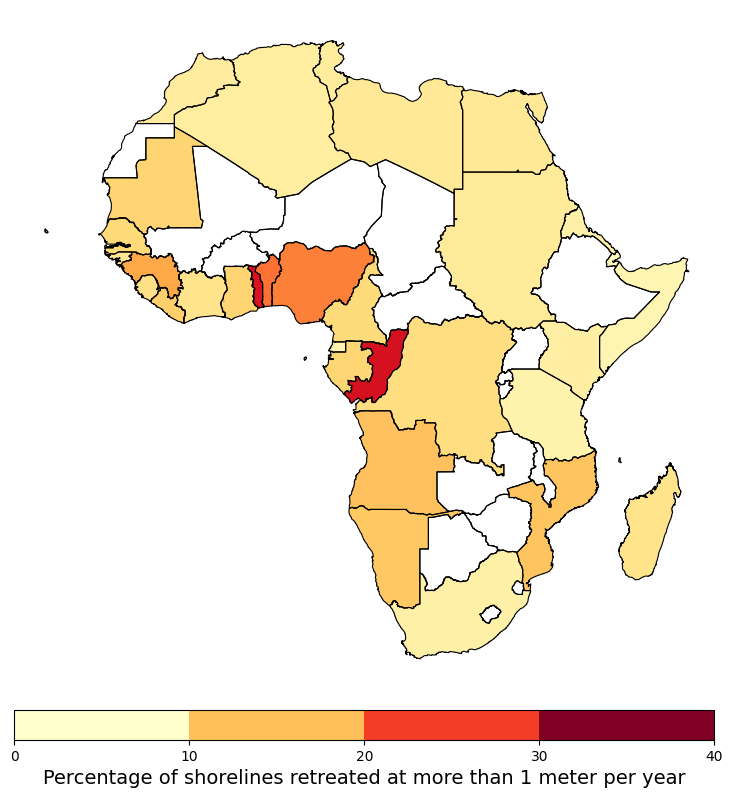

In [15]:
from matplotlib import pyplot as plt
import matplotlib as mpl

param = 'perc_neg1'
title = 'Percentage of shorelines retreated at more than 1 meter per year'

steps = np.ceil((african_countries_coastalchange[param].max()/6)/10)*10
vmin, vmax = 0, np.ceil(african_countries_coastalchange[param].max()/steps)*steps+steps

# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(10,10))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])


# Define colour map
cmap = mpl.cm.YlOrRd
bounds = list(np.arange(vmin,vmax,steps))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
# cbar.set_ticks([])
cbar.set_ticks([i for i in np.arange(vmin,vmax,steps)])
cbar.set_ticklabels(list('{:.0f}'.format(i) for i in (list(np.arange(vmin, vmax, steps)))))
cbar.set_label(title, fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

african_countries_coastalchange.plot(param, ax=ax, cmap=cmap,vmin=vmin, vmax=vmax);
african_countries_coastalchange.geometry.plot(ax=ax, linewidth=0.8, edgecolor='black', facecolor="none");


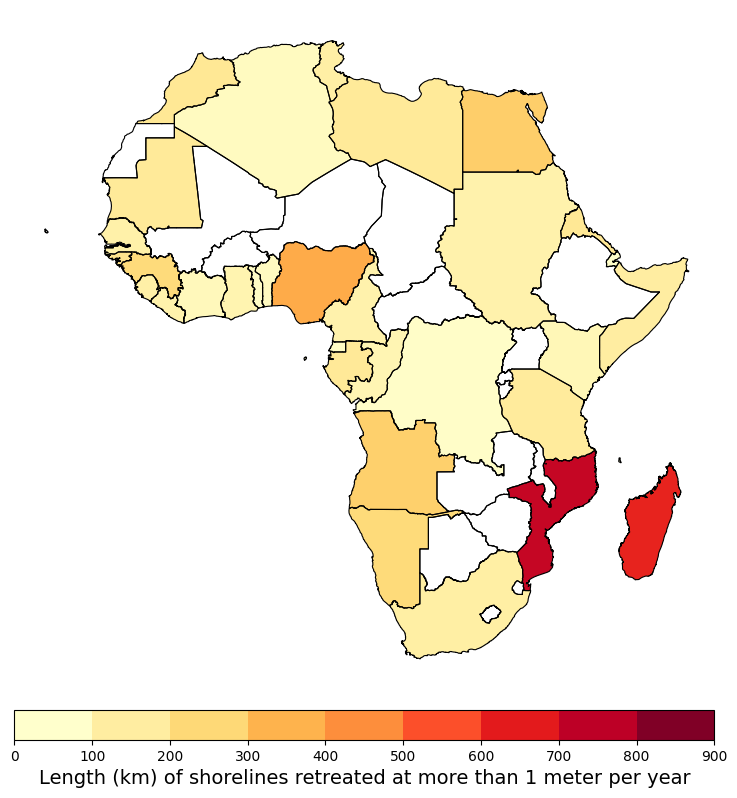

In [21]:
param = 'km_neg1'
title = 'Length (km) of shorelines retreated at more than 1 meter per year'

steps = np.ceil((african_countries_coastalchange[param].max()/10)/100)*100
vmin, vmax = 0, np.ceil(african_countries_coastalchange[param].max()/steps)*steps+steps

# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(10,10))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])


# Define colour map
cmap = mpl.cm.YlOrRd
bounds = list(np.arange(vmin,vmax,steps))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
# cbar.set_ticks([])
cbar.set_ticks([i for i in np.arange(vmin,vmax,steps)])
cbar.set_ticklabels(list('{:.0f}'.format(i) for i in (list(np.arange(vmin, vmax, steps)))))
cbar.set_label(title, fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

african_countries_coastalchange.plot(param, ax=ax, cmap=cmap,vmin=vmin, vmax=vmax);
african_countries_coastalchange.geometry.plot(ax=ax, linewidth=0.8, edgecolor='black', facecolor="none");


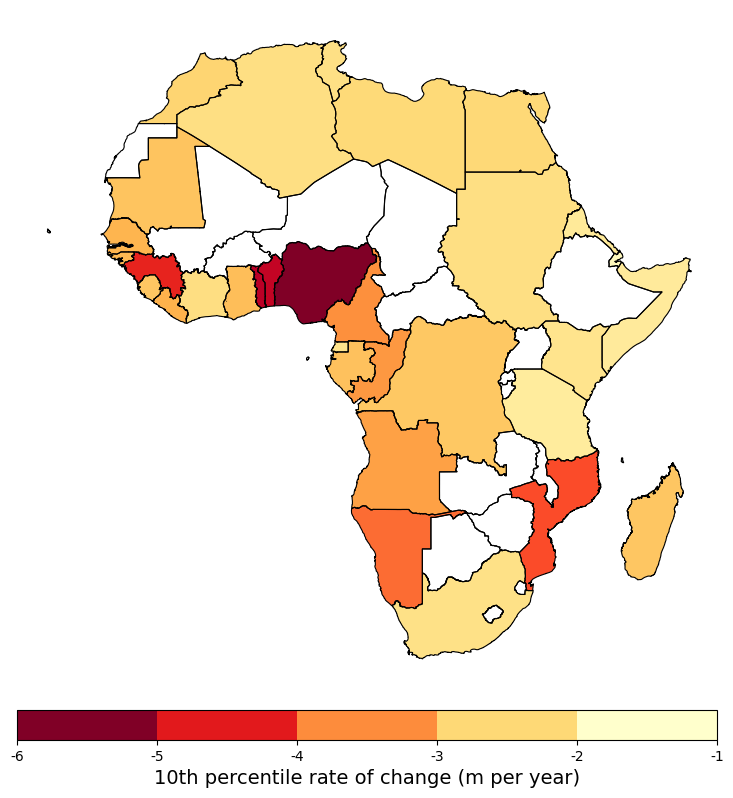

In [23]:
param = 'rate_time_10th'
title = '10th percentile rate of change (m per year)'

steps = np.ceil(abs(african_countries_coastalchange[param].min())/10)
vmin, vmax = np.floor(african_countries_coastalchange[param].min()/steps)*steps+steps, 0 

# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(10,10))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])


# Define colour map
cmap = mpl.cm.YlOrRd_r
bounds = list(np.arange(vmin,vmax,steps))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
# cbar.set_ticks([])
cbar.set_ticks([i for i in np.arange(vmin,vmax,steps)])
cbar.set_ticklabels(list('{:.0f}'.format(i) for i in (list(np.arange(vmin, vmax, steps)))))
cbar.set_label(title, fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

african_countries_coastalchange.plot(param, ax=ax, cmap=cmap,vmin=vmin, vmax=vmax);
african_countries_coastalchange.geometry.plot(ax=ax, linewidth=0.8, edgecolor='black', facecolor="none");


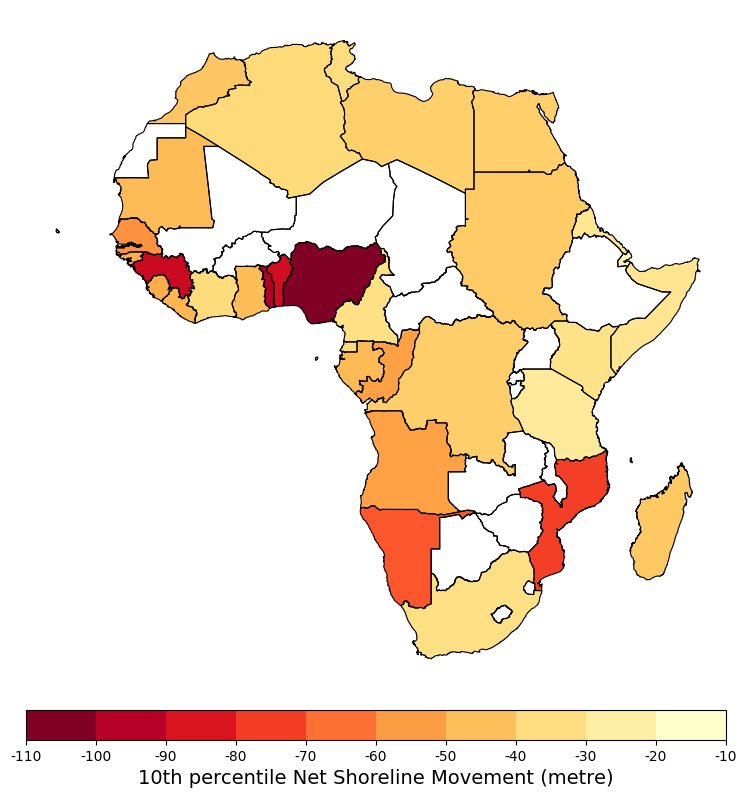

In [24]:
param = 'nsm_10th'
title = '10th percentile Net Shoreline Movement (metre)'

steps = np.floor(abs(african_countries_coastalchange[param].min())/10/10)*10
vmin, vmax = np.floor(african_countries_coastalchange[param].min()/steps)*steps+steps, 0 

# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(10,10))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])


# Define colour map
cmap = mpl.cm.YlOrRd_r
bounds = list(np.arange(vmin,vmax,steps))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
# cbar.set_ticks([])
cbar.set_ticks([i for i in np.arange(vmin,vmax,steps)])
cbar.set_ticklabels(list('{:.0f}'.format(i) for i in (list(np.arange(vmin, vmax, steps)))))
cbar.set_label(title, fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

african_countries_coastalchange.plot(param, ax=ax, cmap=cmap,vmin=vmin, vmax=vmax);
african_countries_coastalchange.geometry.plot(ax=ax, linewidth=0.8, edgecolor='black', facecolor="none");

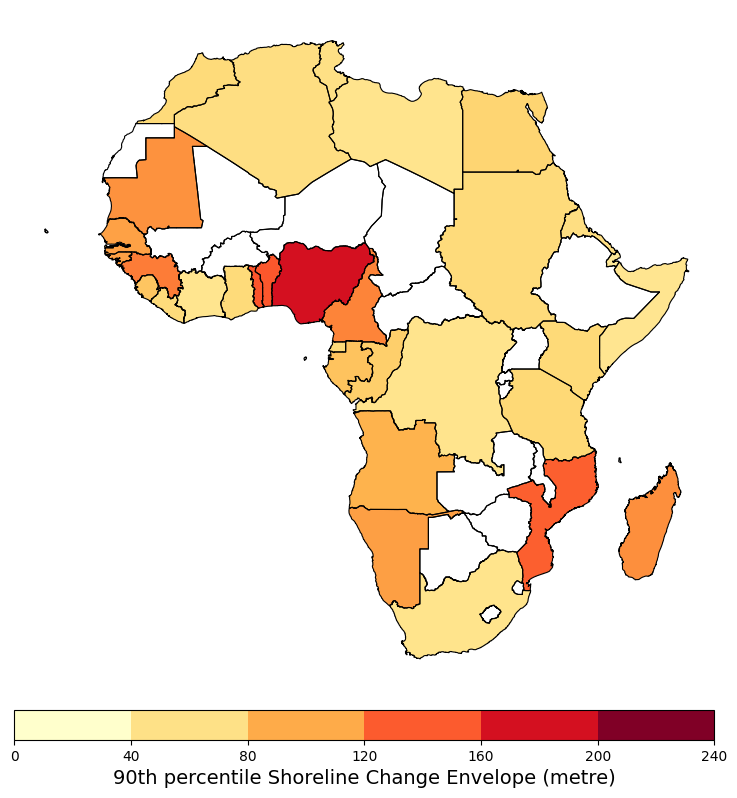

In [22]:
param = 'sce_90th'
title = '90th percentile Shoreline Change Envelope (metre)'

steps = np.ceil((african_countries_coastalchange[param].max()/6)/10)*10
vmin, vmax = 0, np.ceil(african_countries_coastalchange[param].max()/steps)*steps+steps


# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(10,10))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])


# Define colour map
cmap = mpl.cm.YlOrRd
bounds = list(np.arange(vmin,vmax,steps))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
# cbar.set_ticks([])
cbar.set_ticks([i for i in np.arange(vmin,vmax,steps)])
cbar.set_ticklabels(list('{:.0f}'.format(i) for i in (list(np.arange(vmin, vmax, steps)))))
cbar.set_label(title, fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

african_countries_coastalchange.plot(param, ax=ax, cmap=cmap,vmin=vmin, vmax=vmax);
african_countries_coastalchange.geometry.plot(ax=ax, linewidth=0.8, edgecolor='black', facecolor="none");